In [64]:
import numpy as np
import pandas as pd

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.graph_objs as go
import plotly.express    as px
import nltk
import re
import string

from scipy.stats import norm
from wordcloud   import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

from textblob import TextBlob
import re
from collections import Counter

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from IPython.display import Markdown as md


from google.colab import drive
#drive.mount('/content/gdrive')
data_old = pd.read_csv('/content/drive/MyDrive/twitterAustralia/auspol2019.csv')


data_loc_old = pd.read_csv('/content/drive/MyDrive/twitterAustralia/location_geocode.csv')
data_loc = data_loc_old.dropna(subset=['name','lat','long'])
data_loc.to_csv('/content/drive/MyDrive/twitterAustralia/cleanedLocData.csv', index=False)
data_loc.count()

data_old['user_location'] = data_old['user_location'].astype(str)
data_loc['name'] = data_loc['name'].astype(str)

# Perform the merge
merged_df = pd.merge(data_old, data_loc, left_on='user_location', right_on='name', how='left')

# Now let's remove duplicates based on tweet 'id'
merged_df.drop_duplicates(subset=['id'], inplace=True)

# Show the first few rows of the merged DataFrame to verify
print(merged_df.head())
#merged_df.count()


data = merged_df.dropna(subset=['name','lat','long','user_location','full_text','created_at','user_name','user_description','user_created_at'])

# If you want to modify the original DataFrame in-place, you can do:
# df.dropna(subset=['your_column_name'], inplace=True)

# Save the cleaned DataFrame back to a CSV, if needed
data.to_csv('/content/drive/MyDrive/twitterAustralia/cleanedData.csv', index=False)
data.count()
#data.head()


            created_at                   id  \
0  2019-05-20 09:13:44  1130401208756187136   
1  2019-05-20 09:13:43  1130401205367140357   
2  2019-05-20 09:13:33  1130401162782371841   
3  2019-05-20 09:13:29  1130401143551434753   
4  2019-05-20 09:13:23  1130401118666809345   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  @narendramodi @smritiirani Coverage of indian ...            0.0   
2  @workmanalice Do you know if Facebook is relea...            0.0   
3  @vanbadham We all understand we have a compuls...            0.0   
4  Shares were mixed in Asia, with India and Aust...            0.0   

   favorite_count       user_id          user_name user_screen_name  \
0             0.0  9.248486e+07       PIPELINEPETE         jocksjig   
1             0.0  7.756474e+08    Narinder Parmar      nparmar1957   
2             0.0  5.687300e+04        Peter Wells       peterwells   
3     

created_at          129808
id                  129808
full_text           129808
retweet_count       129808
favorite_count      129808
user_id             129808
user_name           129808
user_screen_name    129808
user_description    129808
user_location       129808
user_created_at     129808
name                129808
lat                 129808
long                129808
dtype: int64

There are 129808 rows and 14 columns in the dataset.


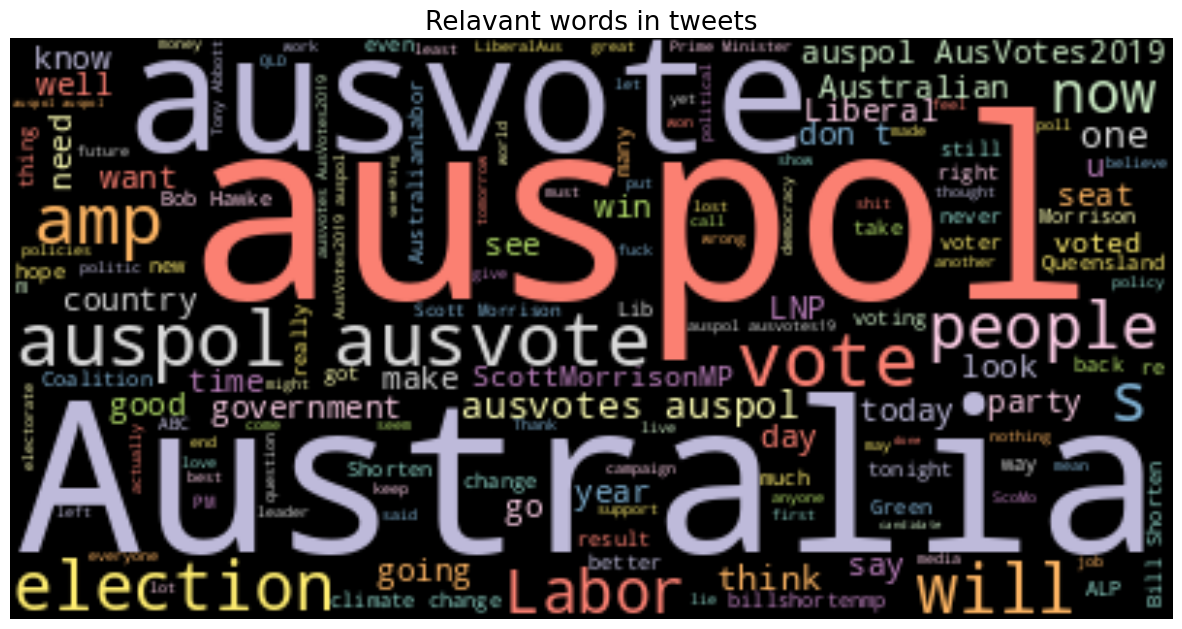

In [65]:
data.describe()
#Number of rows and columns in the dataset
print("There are {} rows and {} columns in the dataset.".format(data.shape[0],data.shape[1]))

text = ",".join(review for review in data.full_text if 'Election' not in review and 'https' not in review and 'Election' not in review)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(6, 6))
plt.title('Relavant words in tweets',fontsize=19)
plt.show()

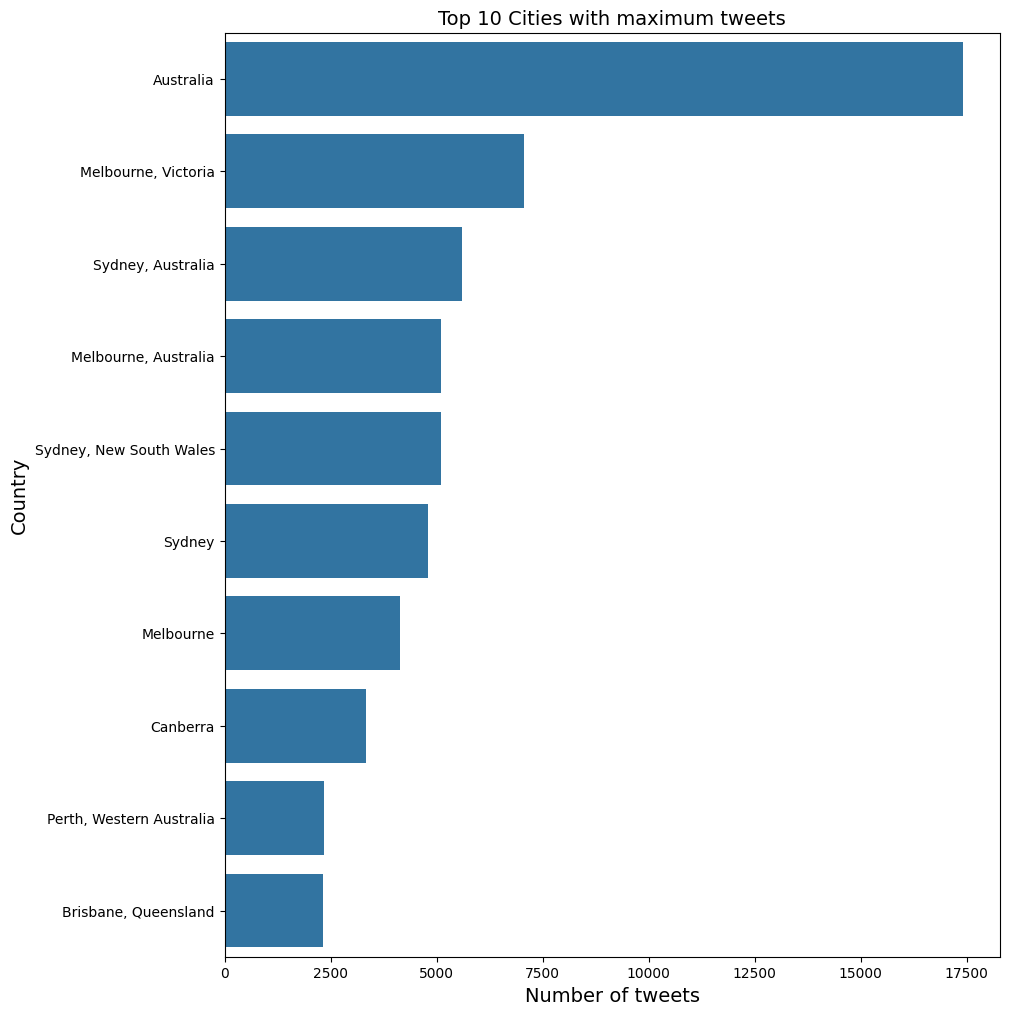

In [66]:
plt.figure(figsize=(10,12))
sns.barplot(x=data["user_location"].value_counts().values[0:10],
            y=data["user_location"].value_counts().index[0:10]);
plt.title("Top 10 Cities with maximum tweets",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Country",fontsize=14)
plt.show()

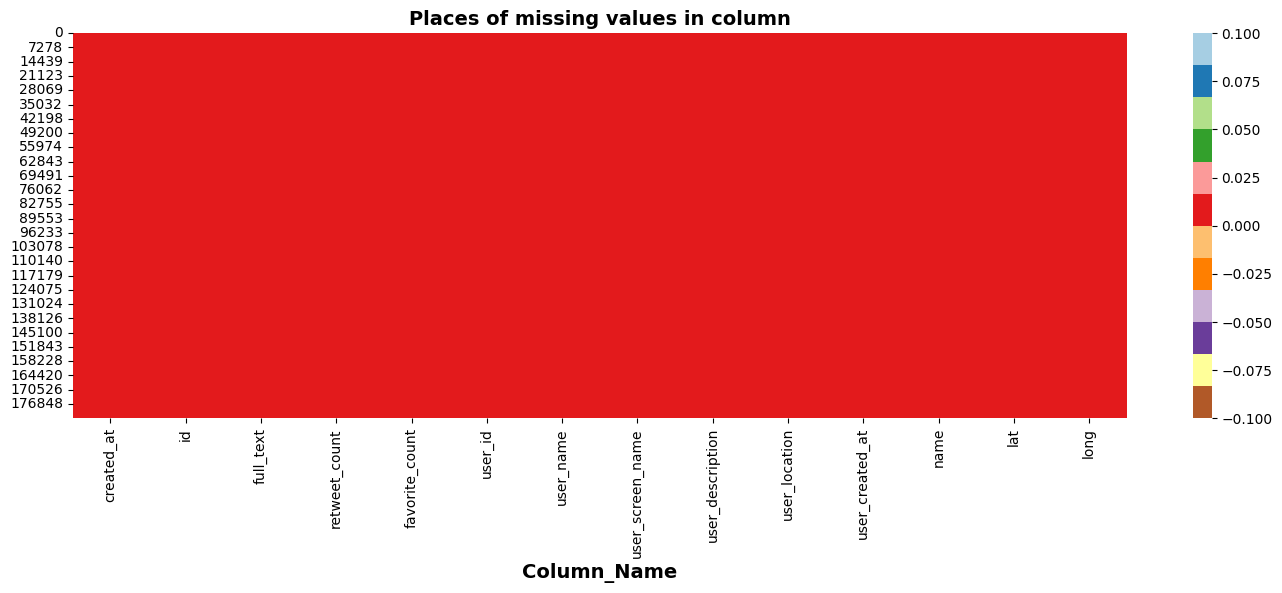

In [67]:
plt.figure(figsize=(17, 5))
sns.heatmap(data.isnull(), cbar=True, cmap='Paired_r')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=14)
plt.show()

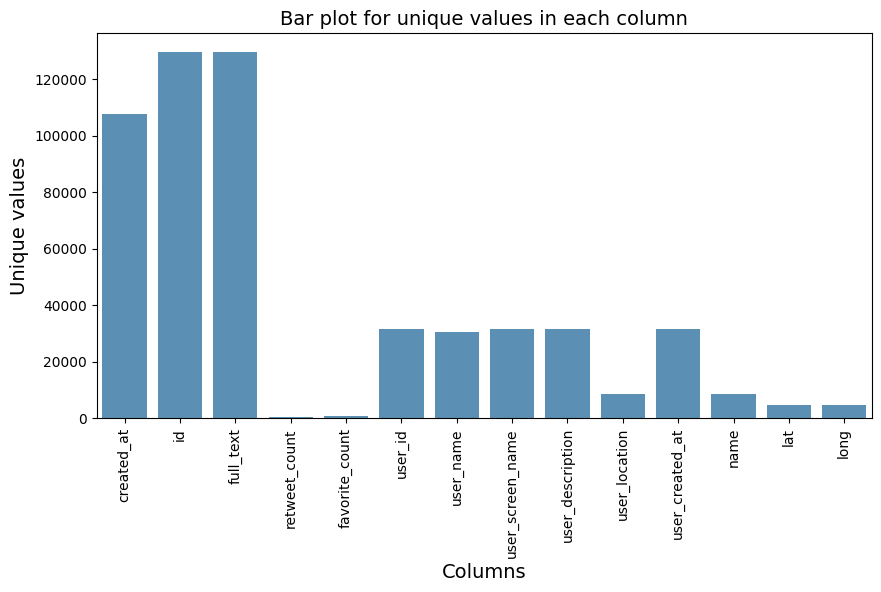

In [68]:
def unique_values_funct(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

udf = unique_values_funct(data)

f, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for unique values in each column', fontsize=14)
plt.ylabel('Unique values', fontsize=14)
plt.xlabel('Columns', fontsize=14)
plt.xticks(rotation=90)
plt.show()

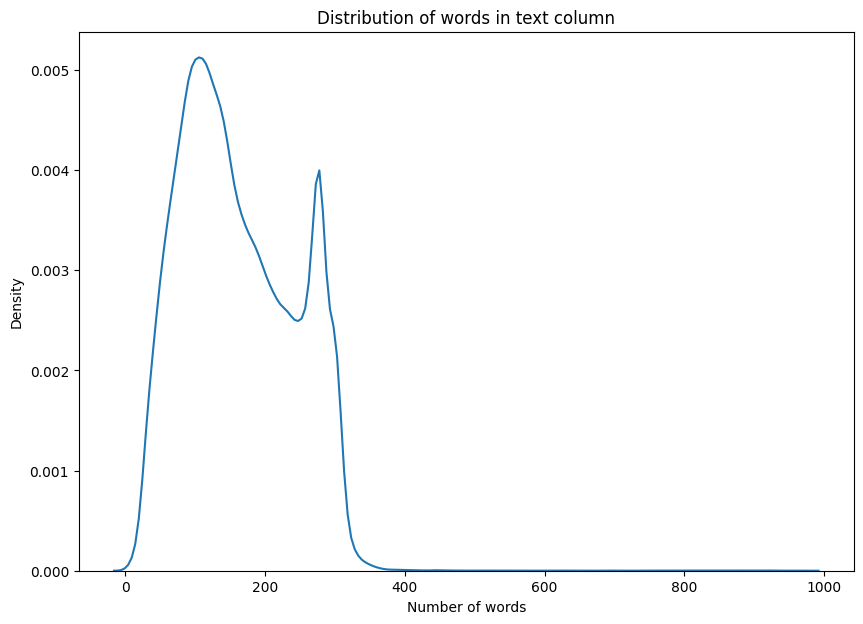

In [69]:
data["num of words in text"] = data["full_text"].apply(lambda x: len(x))
plt.figure(figsize=(10,7))
sns.kdeplot(data["num of words in text"])
plt.title("Distribution of words in text column")
plt.xlabel("Number of words")
plt.show()

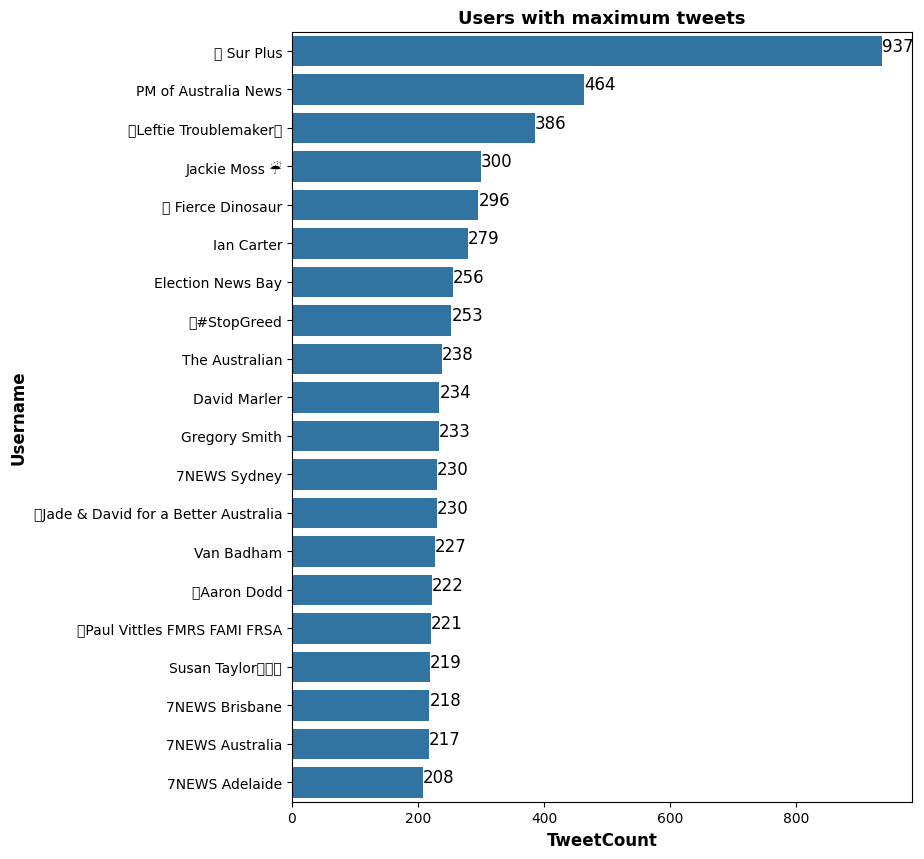

In [70]:
username_count = data['user_name'].value_counts().reset_index().rename(columns={
    'user_name':'tweet_count','index':'user_name'})

plt.figure(figsize=(8, 10))
sns.barplot(y='user_name',x='tweet_count',data=username_count.head(20))
y=username_count['tweet_count'].head(20)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Users with maximum tweets',weight='bold', size=13)
plt.ylabel('Username', size=12, weight='bold')
plt.xlabel('TweetCount', size=12, weight='bold')
plt.show()

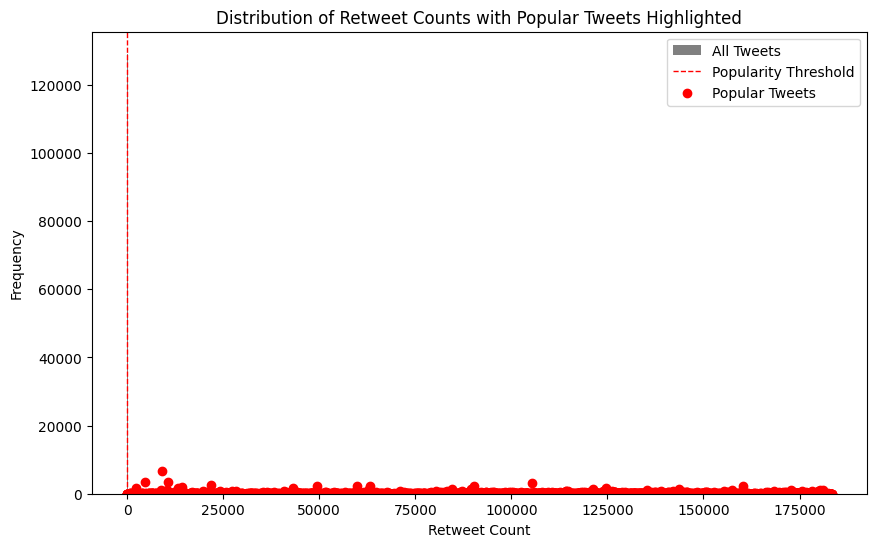

In [71]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#dataLoc = pd.read_csv('/content/drive/MyDrive/twitterAustralia/location_geocode.csv')
#dataLoc.head()
threshold = data['retweet_count'].quantile(0.9)

# Filter for popular tweets
popular_tweets = data[data['retweet_count'] >= threshold]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(data['retweet_count'], bins=50, color='gray', label='All Tweets')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Popularity Threshold')
plt.scatter(popular_tweets.index, popular_tweets['retweet_count'], color='red', label='Popular Tweets')
plt.title('Distribution of Retweet Counts with Popular Tweets Highlighted')
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [72]:
locs = data['user_location'].value_counts()
locs[locs>=10]

Australia                         17409
Melbourne, Victoria                7064
Sydney, Australia                  5595
Melbourne, Australia               5095
Sydney, New South Wales            5092
                                  ...  
Texas                                10
Dunedin New Zealand                  10
Melbourne/Birraranga,Australia       10
Sydney and Melbourne                 10
Blue Mountains, NSW, Australia       10
Name: user_location, Length: 1044, dtype: int64

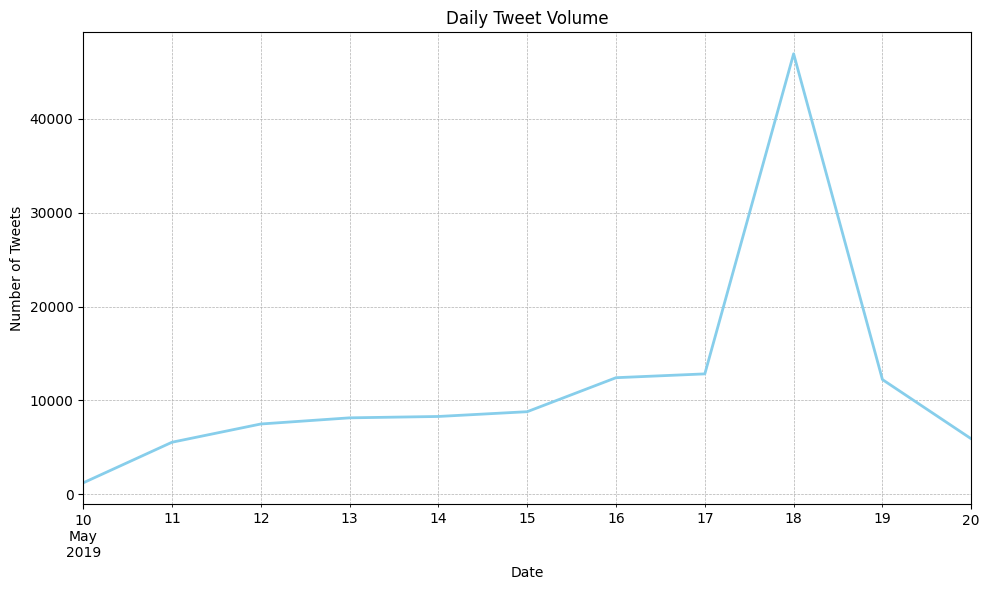

In [73]:
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')

# Resample to get daily tweet counts
daily_tweets = data.resample('D', on='created_at').count()

# Plot
plt.figure(figsize=(10, 6))
daily_tweets['id'].plot(kind='line', color='skyblue', linewidth=2)
plt.title('Daily Tweet Volume')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [74]:
most_popular_tweets = data.sort_values(by=['retweet_count', 'favorite_count'], ascending=False).head(10)

print(most_popular_tweets[['full_text', 'retweet_count', 'favorite_count']])

                                                full_text  retweet_count  \
9202    Shocking defeat for Left in Australia, stunned...         6622.0   
10720   In Australia, conservatives have won another e...         3521.0   
4727    In all the election commentary last night, not...         3439.0   
105467  Meet the PR firm that gave us ScoMo #TheWeekly...         3222.0   
21815   Bob Hawke was the greatest peacetime leader Au...         2435.0   
90255   Do it for your kids.\nDo it for your parents.\...         2379.0   
160213  New Queensland tourism slogan: beautiful one d...         2312.0   
59939   #BREAKING: Scott Morrison has swept to victory...         2256.0   
49371   RIP Australia.\n\nYou forgot about Indigenous ...         2236.0   
63101   Very hard to understand a nation who, through ...         2135.0   

        favorite_count  
9202           15559.0  
10720           9377.0  
4727           11878.0  
105467          6803.0  
21815          12995.0  
90255        

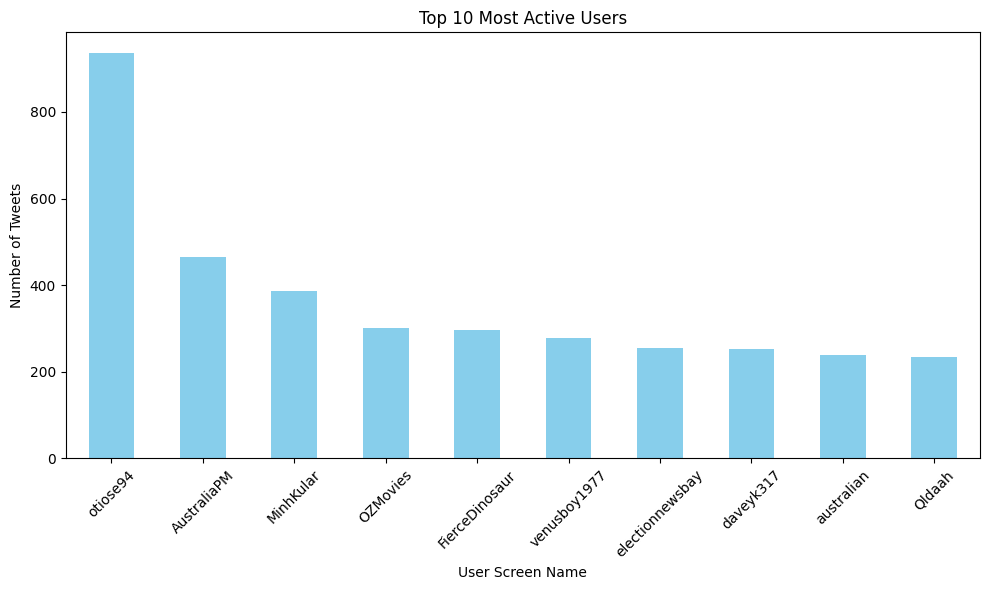

In [75]:
user_activity = data['user_screen_name'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
user_activity.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Active Users')
plt.xlabel('User Screen Name')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
pip install folium

In [80]:
import folium
from folium.plugins import HeatMap

# Example DataFrame 'df' with 'lat' and 'long' columns
# df = ...

# Create a map centered around an average location
map_center = [data['lat'].mean(), data['long'].mean()]
tweet_map = folium.Map(location=map_center, zoom_start=6)

# Add a heatmap to the map
HeatMap(data=data[['lat', 'long']], radius=10).add_to(tweet_map)

# Save the map to an HTML file
tweet_map.save('/content/drive/MyDrive/twitterAustralia/tweet_heatmap.html')